In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import Library

In [2]:
!pip install tensorflow numpy matplotlib

In [3]:
import os
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import TFSMLayer
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

##Upload kaggle.json dan Download Dataset dari Kaggle

In [10]:
# Definisikan path ke folder tujuan
project_dir = "/content/drive/MyDrive/ProjectColab/Dicoding/FundamentalDeepLearning/submission"

# Buat folder jika belum ada
os.makedirs(project_dir, exist_ok=True)

# Pindah ke folder tersebut
%cd "$project_dir"

/content/drive/MyDrive/Project Colab/Dicoding/FundamentalDeepLearning/submission


In [11]:
from google.colab import files
files.upload()  # Upload file kaggle.json kamu

# Setup Kaggle API key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset PlantVillage
!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip -d dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 95% 627M/658M [00:03<00:00, 157MB/s]
100% 658M/658M [00:04<00:00, 169MB/s]


## Explorasi dan Persiapan Dataset


In [12]:
!pip install split-folders
import splitfolders

splitfolders.ratio("dataset/PlantVillage", output="dataset_split", seed=42, ratio=(.7, .15, .15))

Copying files: 20639 files [05:20, 64.45 files/s]


In [14]:
def count_files(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

train_count = count_files('dataset_split/train')
val_count = count_files('dataset_split/val')
test_count = count_files('dataset_split/test')

print(f"Jumlah file di folder train: {train_count}")
print(f"Jumlah file di folder val: {val_count}")
print(f"Jumlah file di folder test: {test_count}")

Jumlah file di folder train: 14441
Jumlah file di folder val: 3089
Jumlah file di folder test: 3109


##Preprocessing dan Data Augmentation

---



In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Ganti path sesuai struktur direktori hasil split
train_dir = 'dataset_split/train'
val_dir = 'dataset_split/val'
test_dir = 'dataset_split/test'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 14440 images belonging to 15 classes.
Found 3089 images belonging to 15 classes.
Found 3109 images belonging to 15 classes.


##Bangun Model CNN (Sequential + Conv2D + Pooling)

In [16]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


##Compile dan Train Model dengan Callback

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.2512 - loss: 2.2949

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


452/452 ━━━━━━━━━━━━━━━━━━━━ 263s 559ms/step - accuracy: 0.2514 - loss: 2.2943 - val_accuracy: 0.5167 - val_loss: 1.4436 - learning_rate: 0.0010
Epoch 2/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.5438 - loss: 1.3872

452/452 ━━━━━━━━━━━━━━━━━━━━ 249s 547ms/step - accuracy: 0.5439 - loss: 1.3869 - val_accuracy: 0.6950 - val_loss: 0.8892 - learning_rate: 0.0010
Epoch 3/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.6718 - loss: 0.9859

452/452 ━━━━━━━━━━━━━━━━━━━━ 239s 528ms/step - accuracy: 0.6719 - loss: 0.9857 - val_accuracy: 0.7501 - val_loss: 0.7418 - learning_rate: 0.0010
Epoch 4/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 270s 546ms/step - accuracy: 0.7440 - loss: 0.7785 - val_accuracy: 0.7316 - val_loss: 0.8143 - learning_rate: 0.0010
Epoch 5/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.7736 - loss: 0.6734

452/452 ━━━━━━━━━━━━━━━━━━━━ 255s 530ms/step - accuracy: 0.7736 - loss: 0.6733 - val_accuracy: 0.8446 - val_loss: 0.4387 - learning_rate: 0.0010
Epoch 6/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 239s 527ms/step - accuracy: 0.8184 - loss: 0.5404 - val_accuracy: 0.8012 - val_loss: 0.6428 - learning_rate: 0.0010
Epoch 7/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 238s 527ms/step - accuracy: 0.8354 - loss: 0.4911 - val_accuracy: 0.8265 - val_loss: 0.5284 - learning_rate: 0.0010
Epoch 8/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.8581 - loss: 0.4267
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
452/452 ━━━━━━━━━━━━━━━━━━━━ 245s 541ms/step - accuracy: 0.8581 - loss: 0.4267 - val_accuracy: 0.8453 - val_loss: 0.4628 - learning_rate: 0.0010
Epoch 9/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8922 - loss: 0.3129

452/452 ━━━━━━━━━━━━━━━━━━━━ 247s 546ms/step - accuracy: 0.8922 - loss: 0.3129 - val_accuracy: 0.9207 - val_loss: 0.2426 - learning_rate: 5.0000e-04
Epoch 10/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 253s 527ms/step - accuracy: 0.9104 - loss: 0.2657 - val_accuracy: 0.9032 - val_loss: 0.2805 - learning_rate: 5.0000e-04
Epoch 11/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9146 - loss: 0.2488

452/452 ━━━━━━━━━━━━━━━━━━━━ 240s 531ms/step - accuracy: 0.9146 - loss: 0.2488 - val_accuracy: 0.9275 - val_loss: 0.2066 - learning_rate: 5.0000e-04
Epoch 12/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 238s 525ms/step - accuracy: 0.9152 - loss: 0.2481 - val_accuracy: 0.8689 - val_loss: 0.4130 - learning_rate: 5.0000e-04
Epoch 13/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9211 - loss: 0.2350

452/452 ━━━━━━━━━━━━━━━━━━━━ 239s 529ms/step - accuracy: 0.9211 - loss: 0.2350 - val_accuracy: 0.9346 - val_loss: 0.1957 - learning_rate: 5.0000e-04
Epoch 14/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 260s 524ms/step - accuracy: 0.9292 - loss: 0.2037 - val_accuracy: 0.8886 - val_loss: 0.3310 - learning_rate: 5.0000e-04
Epoch 15/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 235s 519ms/step - accuracy: 0.9230 - loss: 0.2230 - val_accuracy: 0.9016 - val_loss: 0.2590 - learning_rate: 5.0000e-04
Epoch 16/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.9259 - loss: 0.2042
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
452/452 ━━━━━━━━━━━━━━━━━━━━ 255s 504ms/step - accuracy: 0.9259 - loss: 0.2042 - val_accuracy: 0.9200 - val_loss: 0.2453 - learning_rate: 5.0000e-04
Epoch 17/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 228s 505ms/step - accuracy: 0.9432 - loss: 0.1688 - val_accuracy: 0.8996 - val_loss: 0.2813 - learning_rate: 2.5000e-04
Epoch 18/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 229s 507ms/s

##Evaluasi Model dan Plot Akurasi/Loss

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.9407 - loss: 0.1646
Akurasi test: 0.9466


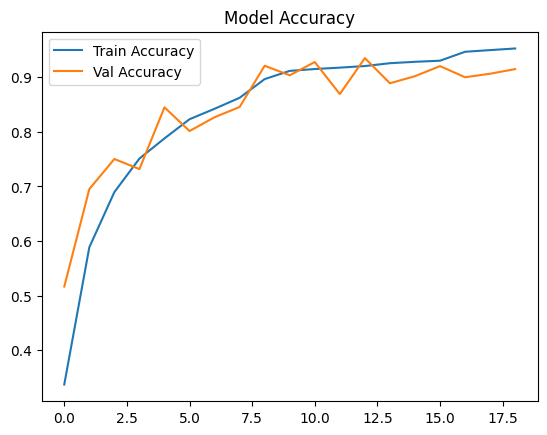

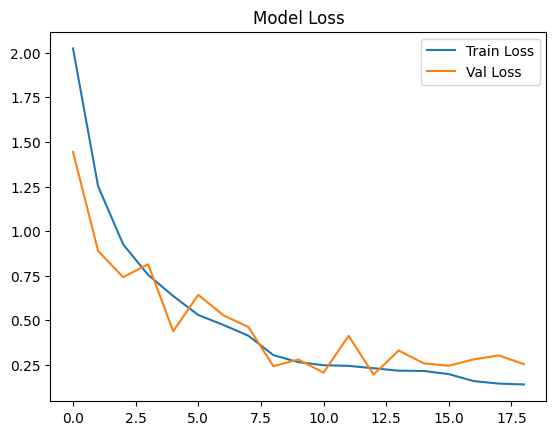

In [18]:
# Evaluasi
test_loss, test_acc = model.evaluate(test_generator)
print(f"Akurasi test: {test_acc:.4f}")

# Visualisasi Akurasi dan Loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

print()
print()
print()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [19]:
# Load model terbaik yang sudah tersimpan
model = load_model("best_model.h5")

# Kompilasi ulang model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Lanjutkan training dengan epoch tambahan
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

# Evaluasi ulang
test_loss, test_acc = model.evaluate(test_generator)
print(f"Akurasi test setelah fine-tune: {test_acc:.4f}")

Epoch 1/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 242s 525ms/step - accuracy: 0.9449 - loss: 0.1708 - val_accuracy: 0.9204 - val_loss: 0.2267 - learning_rate: 1.0000e-04
Epoch 2/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 231s 511ms/step - accuracy: 0.9494 - loss: 0.1483 - val_accuracy: 0.9107 - val_loss: 0.2527 - learning_rate: 1.0000e-04
Epoch 3/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.9473 - loss: 0.1501

452/452 ━━━━━━━━━━━━━━━━━━━━ 263s 513ms/step - accuracy: 0.9473 - loss: 0.1501 - val_accuracy: 0.9369 - val_loss: 0.1783 - learning_rate: 1.0000e-04
Epoch 4/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 262s 513ms/step - accuracy: 0.9534 - loss: 0.1366 - val_accuracy: 0.9136 - val_loss: 0.2478 - learning_rate: 1.0000e-04
Epoch 5/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 231s 511ms/step - accuracy: 0.9519 - loss: 0.1380 - val_accuracy: 0.9165 - val_loss: 0.2482 - learning_rate: 1.0000e-04
Epoch 6/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.9567 - loss: 0.1253
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
452/452 ━━━━━━━━━━━━━━━━━━━━ 231s 512ms/step - accuracy: 0.9567 - loss: 0.1253 - val_accuracy: 0.9288 - val_loss: 0.2108 - learning_rate: 1.0000e-04
Epoch 7/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 262s 512ms/step - accuracy: 0.9561 - loss: 0.1240 - val_accuracy: 0.9265 - val_loss: 0.2192 - learning_rate: 5.0000e-05
Epoch 8/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 264s 515ms/step - 

98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9522 - loss: 0.1425
Akurasi test: 0.9485



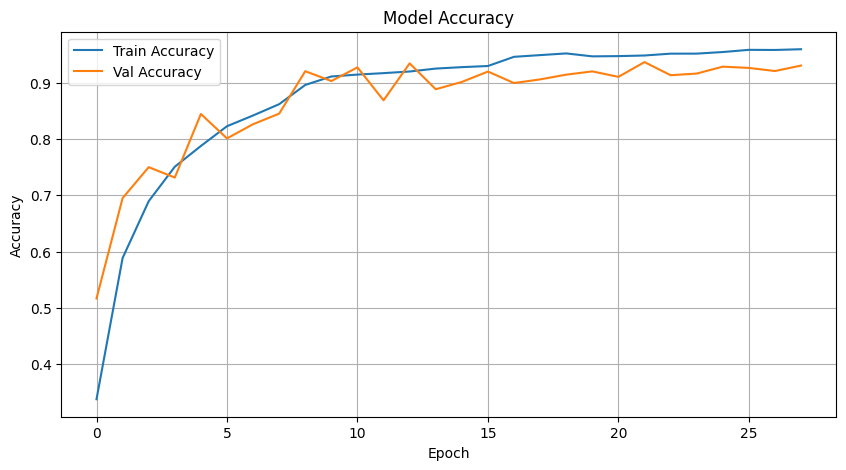

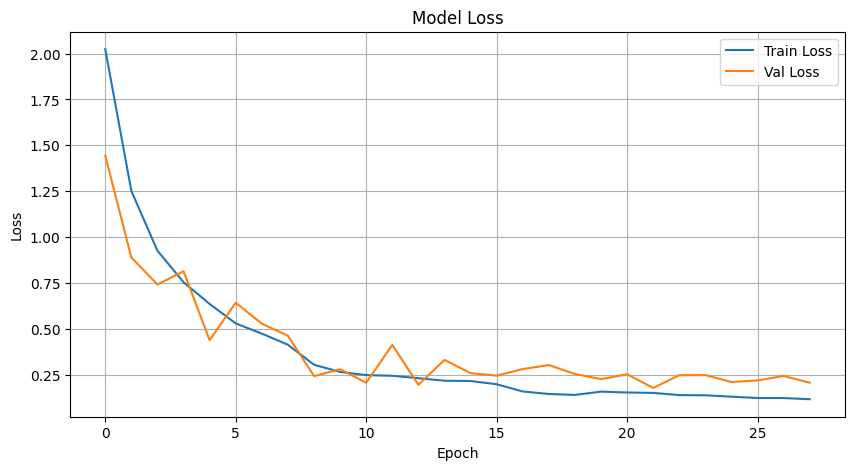

In [20]:
# Evaluasi
test_loss, test_acc = model.evaluate(test_generator)
print(f"Akurasi test: {test_acc:.4f}")

# Gabungkan history
full_acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
full_val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
full_loss = history.history['loss'] + fine_tune_history.history['loss']
full_val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

# Plot Akurasi
print()
plt.figure(figsize=(10, 5))
plt.plot(full_acc, label='Train Accuracy')
plt.plot(full_val_acc, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
print()
print()
print()
plt.figure(figsize=(10, 5))
plt.plot(full_loss, label='Train Loss')
plt.plot(full_val_loss, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

##Simpan Model ke 3 Format


In [31]:
# 1. Load model terbaik
from keras.models import load_model

model = load_model("best_model.h5")

# 2. Simpan ke SavedModel
model.export("saved_model/")  # untuk TFLite dan TFJS

# 3. Konversi ke TFLite
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/")
tflite_model = converter.convert()

# Buat folder
os.makedirs("tflite", exist_ok=True)

with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# 4. Simpan label (opsional, untuk inferensi mobile)
class_names = list(train_generator.class_indices.keys())
with open("tflite/label.txt", "w") as f:
    f.write("\n".join(class_names))

# 5. Konversi ke TFJS
!pip install tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model saved_model tfjs_model

Saved artifact at 'saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  138272615891408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138272598448976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138272598444560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138272598449552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138272598442256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138272598452240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138272598452432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138272598448208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138272598449936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138272598453392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138272598455312: T

##Inference Model

Saving images.jpeg to images.jpeg


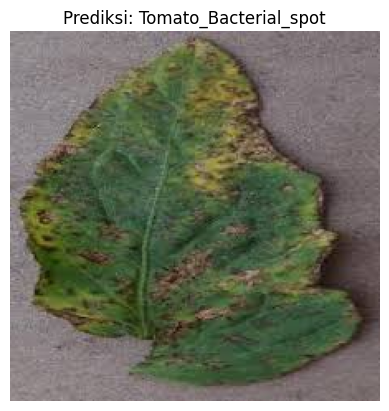

In [32]:
# Upload gambar
uploaded = files.upload()

# Load model inference dari SavedModel
model = TFSMLayer('saved_model/', call_endpoint='serve')

# Mapping kelas
class_names = list(train_generator.class_indices.keys())

# Prediksi
for fname in uploaded.keys():
    img = image.load_img(fname, target_size=(224, 224))  # sesuaikan ukuran input model
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

    prediction = model(img_array)
    predicted_class = np.argmax(prediction[0])

    # Visualisasi
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {class_names[predicted_class]}")
    plt.show()

In [ ]:
!pip install pipreqs

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.0 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=2f37ff69bdb0a909e7214c95c0b8a436d605ef6b46fbb13d9ce3b8d6b41eb46d
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.12.3 which is incompatible.


In [ ]:
!pipreqs --scan-notebooks

INFO: Successfully saved requirements file in /content/requirements.txt
